PATAKA files
============

First import some general libraries

In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut, GridSearchCV
import scipy.io
import os
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from matplotlib.lines import Line2D

# Non-thresholded files

In [9]:
path_code = os.getcwd()
PATAKA_dataset = scipy.io.loadmat(os.path.join(path_code, "../Data/PATAKA_regr.mat"))
ar_m = PATAKA_dataset["ar_ptk"]
af_m = PATAKA_dataset["af_ptk"]
ID_m = PATAKA_dataset["ID"]
label_m = PATAKA_dataset["label"]
y_m = PATAKA_dataset["slp_ptk"]

In [10]:
ar = np.zeros([len(ar_m[0]), 1])
for i in range(len(ar_m[0])):
    ar[i,0] = ar_m[0][i][0][0]

af = np.zeros([len(af_m[0]), 1])
for i in range(len(af_m[0])):
        af[i,0] = af_m[0][i][0][0]

ID = []
label = []
y = np.zeros([y_m.size, 1])
for i in range(ID_m.size):
    ID.append(ID_m[0][i][0])
    label.append(label_m[0][i][0][0])
    y[i,0] = y_m[0][i][0][0]
y = y.ravel()

X = np.stack((ar, af), axis=-1)
X = X.reshape(18, -1)

# SVR

***Linear kernel***

In [23]:
loo=LeaveOneOut()
y_true = []
y_pred = []
sample_ID = []
sample_label = []
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 10],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ID_test = ID[test_index[0]]
    label_test = label[test_index[0]]
    # Modello SVR
    svr = SVR(kernel='linear')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])
    sample_ID.append(ID_test)
    sample_label.append(label_test)


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))

Nested LOOCV RMSE: 1.41


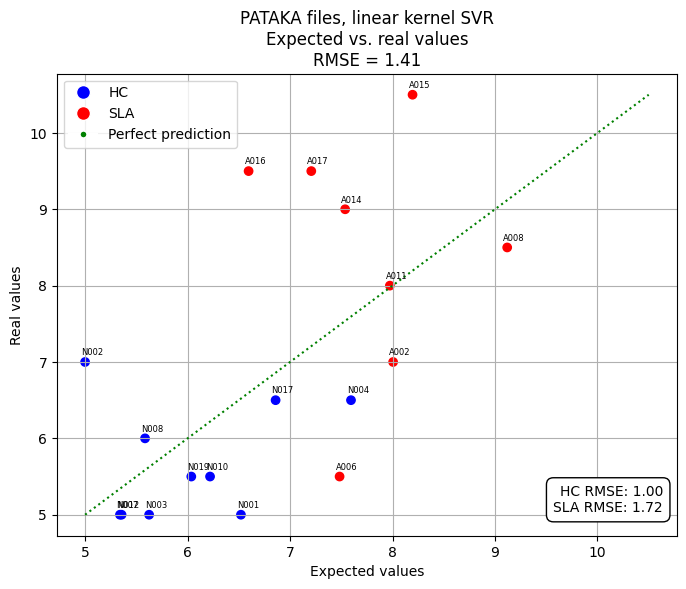

In [25]:
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
colors = ['blue' if label == 0 else 'red' for label in sample_label]
plt.scatter(y_p, y_t, color=colors, label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='green', linestyle='dotted', label='Perfect prediction')

for i, id_ in enumerate(sample_ID):
    plt.annotate(f'{id_}', 
                 (y_p[i], y_t[i]),
                 textcoords="offset points",  # Usa coordinate di offset
                 xytext=(5,5),  # Posiziona l'annotazione leggermente a lato e sopra il punto
                 ha='center',  # Allinea orizzontalmente il testo
                 fontsize=6)


text = f"HC RMSE: {np.sqrt(mean_squared_error(y_t[:9], y_p[:9])):.2f}\nSLA RMSE: {np.sqrt(mean_squared_error(y_t[9:], y_p[9:])):.2f}"
plt.annotate(text, xy=(1, 0), xycoords='axes fraction',
             xytext=(-10, 15), textcoords='offset points',
             ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))


plt.xlabel('Expected values')
plt.ylabel('Real values')
legend_patches = legend_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='HC'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='SLA'),
                Line2D([0],[0], marker=".", color='w', markerfacecolor='green', markersize=10, label='Perfect prediction')]

plt.title('PATAKA files, linear kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend(handles=legend_patches)

plt.grid(True)
plt.show()

***Sigmoidal kernel***

In [26]:
loo=LeaveOneOut()
y_true = []
y_pred = []
sample_ID = []
sample_label = []
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ID_test = ID[test_index[0]]
    label_test = label[test_index[0]]
    # Modello SVR
    svr = SVR(kernel='sigmoid')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])
    sample_ID.append(ID_test)
    sample_label.append(label_test)


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))

Nested LOOCV RMSE: 1.82


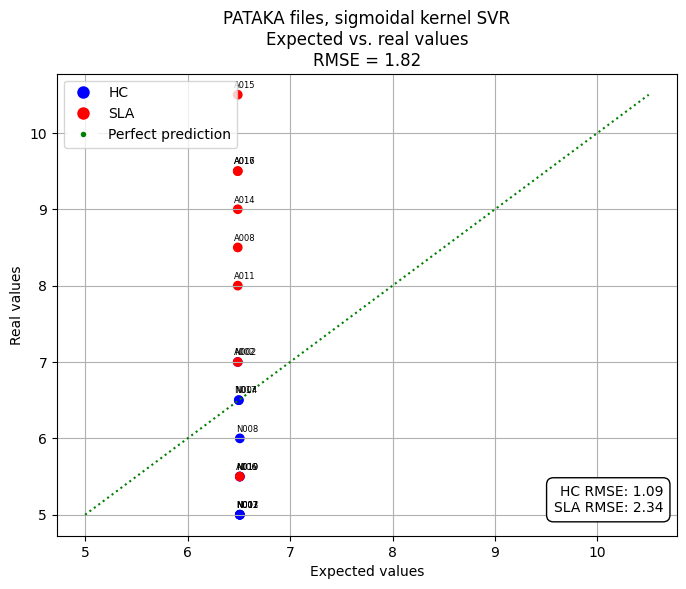

In [27]:
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
colors = ['blue' if label == 0 else 'red' for label in sample_label]
plt.scatter(y_p, y_t, color=colors, label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='green', linestyle='dotted', label='Perfect prediction')

for i, id_ in enumerate(sample_ID):
    plt.annotate(f'{id_}', 
                 (y_p[i], y_t[i]),
                 textcoords="offset points",  # Usa coordinate di offset
                 xytext=(5,5),  # Posiziona l'annotazione leggermente a lato e sopra il punto
                 ha='center',  # Allinea orizzontalmente il testo
                 fontsize=6)


text = f"HC RMSE: {np.sqrt(mean_squared_error(y_t[:9], y_p[:9])):.2f}\nSLA RMSE: {np.sqrt(mean_squared_error(y_t[9:], y_p[9:])):.2f}"
plt.annotate(text, xy=(1, 0), xycoords='axes fraction',
             xytext=(-10, 15), textcoords='offset points',
             ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))


plt.xlabel('Expected values')
plt.ylabel('Real values')
legend_patches = legend_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='HC'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='SLA'),
                Line2D([0],[0], marker=".", color='w', markerfacecolor='green', markersize=10, label='Perfect prediction')]

plt.title('PATAKA files, sigmoidal kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend(handles=legend_patches)

plt.grid(True)
plt.show()

***RBF kernel***

In [28]:
loo=LeaveOneOut()
y_true = []
y_pred = []
sample_ID = []
sample_label = []
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

In [29]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ID_test = ID[test_index[0]]
    label_test = label[test_index[0]]
    # Modello SVR
    svr = SVR(kernel='rbf')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])
    sample_ID.append(ID_test)
    sample_label.append(label_test)


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))

Nested LOOCV RMSE: 1.79


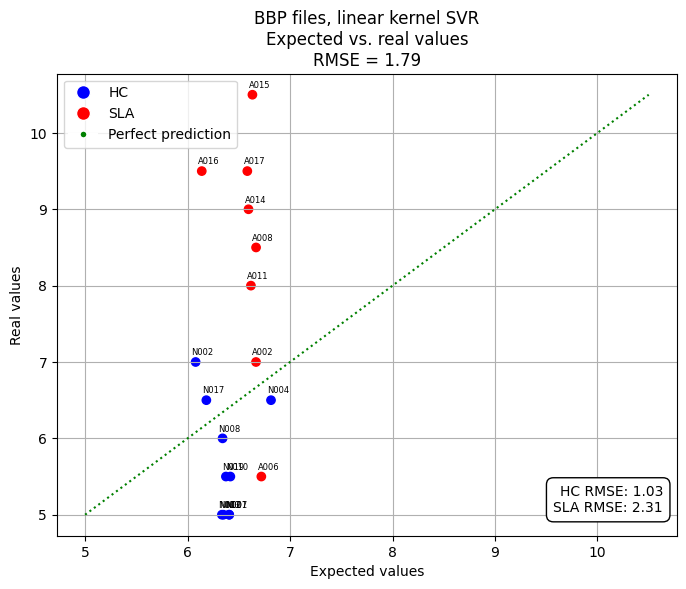

In [30]:
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
colors = ['blue' if label == 0 else 'red' for label in sample_label]
plt.scatter(y_p, y_t, color=colors, label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='green', linestyle='dotted', label='Perfect prediction')

for i, id_ in enumerate(sample_ID):
    plt.annotate(f'{id_}', 
                 (y_p[i], y_t[i]),
                 textcoords="offset points",  # Usa coordinate di offset
                 xytext=(5,5),  # Posiziona l'annotazione leggermente a lato e sopra il punto
                 ha='center',  # Allinea orizzontalmente il testo
                 fontsize=6)


text = f"HC RMSE: {np.sqrt(mean_squared_error(y_t[:9], y_p[:9])):.2f}\nSLA RMSE: {np.sqrt(mean_squared_error(y_t[9:], y_p[9:])):.2f}"
plt.annotate(text, xy=(1, 0), xycoords='axes fraction',
             xytext=(-10, 15), textcoords='offset points',
             ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))


plt.xlabel('Expected values')
plt.ylabel('Real values')
legend_patches = legend_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='HC'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='SLA'),
                Line2D([0],[0], marker=".", color='w', markerfacecolor='green', markersize=10, label='Perfect prediction')]

plt.title('BBP files, linear kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend(handles=legend_patches)

plt.grid(True)

# Neural network

In [31]:
nn = MLPRegressor(
    activation='logistic',
    hidden_layer_sizes=(10, 100, 200),
    alpha=0.001,
    random_state=20,
    early_stopping=False,
    solver='adam',
    max_iter= 3500
)
param_grid = {
    'hidden_layer_sizes': [ (10, 50), (10, 100),(10, 30, 100), (10, 50, 100), (10, 100, 100)], 
    'alpha': [0.0001, 0.001, 0.01],
}

# Creare oggetto LOOCV
loo = LeaveOneOut()
y_pred = []
y_true = []
sample_ID = []
sample_label = []
# Loop su ogni iterazione di LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ID_test = ID[test_index[0]]
    label_test = label[test_index[0]]    
    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_grid = GridSearchCV(estimator=nn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', error_score='raise')
    inner_grid.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = inner_grid.best_params_
    best_model = inner_grid.best_estimator_
    # Fit del modello con i migliori parametri sul training set esterno
    best_model.fit(X_train, y_train)

    # Previsioni sul set di test corrente
    y_pred.extend(np.clip(best_model.predict(X_test), 5,25))
    y_true.extend(y_test)
    sample_ID.append(ID_test)
    sample_label.append(label_test)

y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))

Nested LOOCV RMSE: 1.26


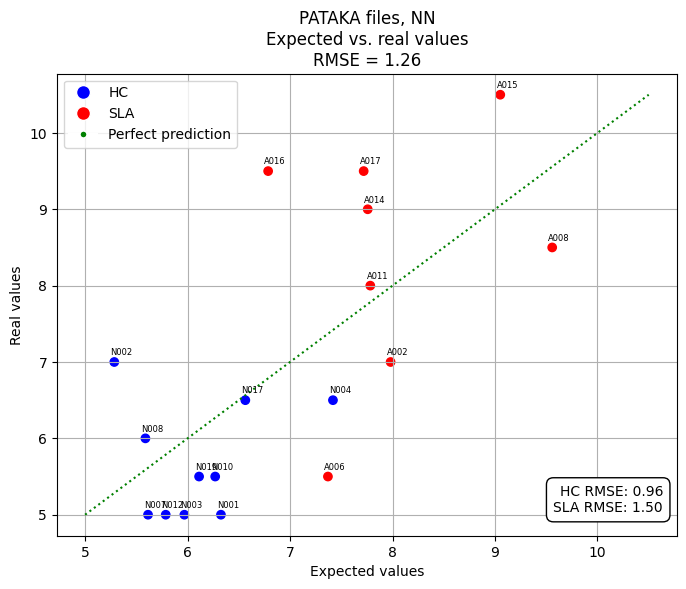

In [33]:
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
colors = ['blue' if label == 0 else 'red' for label in sample_label]
plt.scatter(y_p, y_t, color=colors, label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='green', linestyle='dotted', label='Perfect prediction')

for i, id_ in enumerate(sample_ID):
    plt.annotate(f'{id_}', 
                 (y_p[i], y_t[i]),
                 textcoords="offset points",  # Usa coordinate di offset
                 xytext=(5,5),  # Posiziona l'annotazione leggermente a lato e sopra il punto
                 ha='center',  # Allinea orizzontalmente il testo
                 fontsize=6)


text = f"HC RMSE: {np.sqrt(mean_squared_error(y_t[:9], y_p[:9])):.2f}\nSLA RMSE: {np.sqrt(mean_squared_error(y_t[9:], y_p[9:])):.2f}"
plt.annotate(text, xy=(1, 0), xycoords='axes fraction',
             xytext=(-10, 15), textcoords='offset points',
             ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))


plt.xlabel('Expected values')
plt.ylabel('Real values')
legend_patches = legend_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='HC'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='SLA'),
                Line2D([0],[0], marker=".", color='w', markerfacecolor='green', markersize=10, label='Perfect prediction')]

plt.title('PATAKA files, NN\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend(handles=legend_patches)

plt.grid(True)

# Thresholded files

In [10]:
path_code = os.getcwd()
PATAKA_dataset = scipy.io.loadmat(os.path.join(path_code, "../Data/PATAKA_th_regr.mat"))
ar_m = PATAKA_dataset["ar_th_ptk"]
af_m = PATAKA_dataset["af_th_ptk"]
y_m = PATAKA_dataset["slp"]

In [11]:
ar = np.zeros([len(ar_m[0]), 1])
for i in range(len(ar_m[0])):
    ar[i,0] = ar_m[0][i][0][0]

af = np.zeros([len(af_m[0]), 1])
for i in range(len(af_m[0])):
        af[i,0] = af_m[0][i][0][0]

y = np.zeros([len(y_m[0]), 1])
for i in range(len(y_m[0])):
        y[i,0] = y_m[0][i][0][0]

y = y.ravel()

X = np.stack((ar, af), axis=-1)
X = X.reshape(19, -1)

# SVR

***Linear kernel***

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 10, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 10, 'epsilon': 0.01}

{'C': 0.5, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.1, 'epsilon': 1}

{'C': 0.1, 'epsilon': 1}

{'C': 0.5, 'epsilon': 1}

{'C': 0.05, 'epsilon': 1}

{'C': 0.1, 'epsilon': 1}

Nested LOOCV RMSE: 1.91


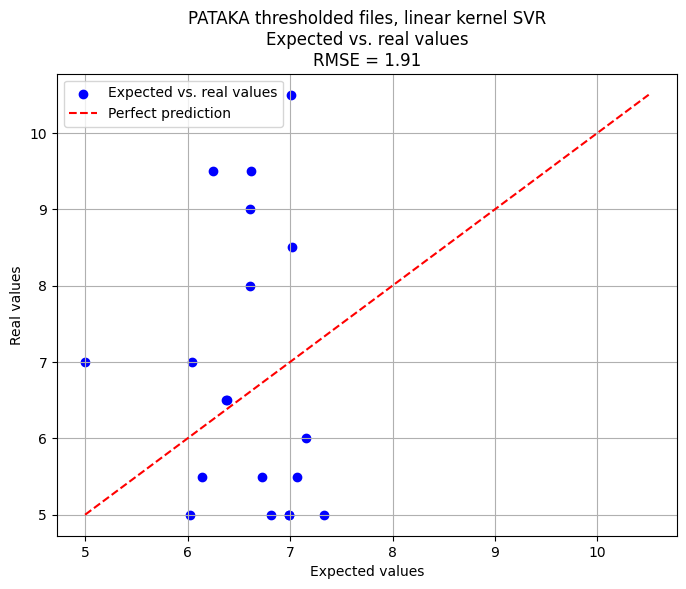

In [12]:
loo=LeaveOneOut()
y_true = []
y_pred = []
model = SVR(kernel='linear')
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 10],
    'epsilon': [0.01, 0.1, 0.5, 1]
}
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='linear')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('PATAKA thresholded files, linear kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***Sigmoidal kernel***

In [13]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 0.5}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0

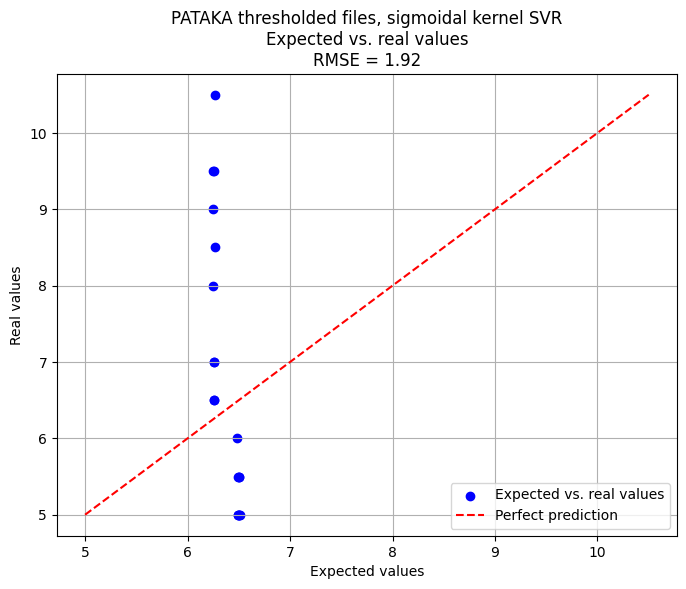

In [14]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='sigmoid')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('PATAKA thresholded files, sigmoidal kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

***RBF kernel***

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.001, 'coef0': 0.0, 'epsilon': 0.01, 'gamma': 0.1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.1, 'coef0': 0.0, 'epsilon': 0.1, 'gamma': 1}

{'C': 0.1, 'coef0': 0.0, 'epsilon':

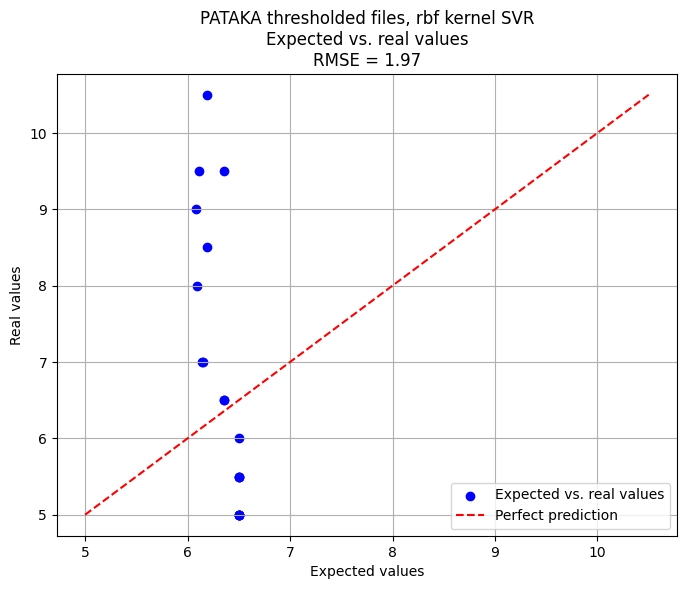

In [15]:
loo=LeaveOneOut()
y_true = []
y_pred = []

param_grid = {
    'C': [0.001, 0.01, 0.1],
    'gamma': [0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modello SVR
    svr = SVR(kernel='rbf')

    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=inner_loo, scoring='neg_mean_squared_error', error_score='raise')
    grid_search.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = grid_search.best_params_
    best_svr = grid_search.best_estimator_
    print(f'{best_params}\n')

    # Fit del modello con i migliori parametri sul training set esterno e predizione
    best_svr.fit(X_train, y_train)
    y_pred.append(np.clip(best_svr.predict(X_test), 5, 25)[0])
    y_true.append(y_test[0])


y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('PATAKA thresholded files, rbf kernel SVR\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()

# Neural network

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 100)}

{'alpha': 0.01, 'hidden_layer_sizes': (10, 50, 200)}

{'alpha': 0.01, 'hidden_la

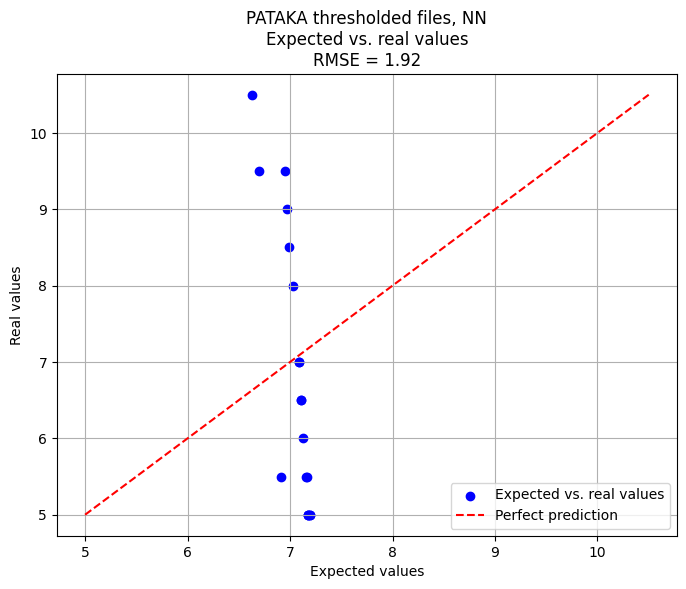

In [16]:
nn = MLPRegressor(
    activation='logistic',
    hidden_layer_sizes=(10, 100, 200),
    alpha=0.001,
    random_state=20,
    early_stopping=False,
    solver='adam',
    max_iter= 5000
)
param_grid = {
    'hidden_layer_sizes': [ (10, 50), (10, 100), (20, 50, 200), (10, 30, 100), (10, 50, 100), (10, 50, 200), (10, 100, 100)], 
    'alpha': [0.0001, 0.001, 0.01],
}

# Creare oggetto LOOCV
loo = LeaveOneOut()
y_pred = []
y_true = []

# Loop su ogni iterazione di LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Grid search con LOOCV interno per selezionare i migliori parametri
    inner_grid = GridSearchCV(estimator=nn, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', error_score='raise')
    inner_grid.fit(X_train, y_train)

    # Migliori parametri trovati nella grid search interna
    best_params = inner_grid.best_params_
    best_model = inner_grid.best_estimator_
    print(f"{best_params}\n")
    # Fit del modello con i migliori parametri sul training set esterno
    best_model.fit(X_train, y_train)

    # Previsioni sul set di test corrente
    y_pred.extend(np.clip(best_model.predict(X_test), 5,25))
    y_true.extend(y_test)

y_t = np.zeros(len(y_true))
for i in range(len(y_true)):
    if type(y_true[i]) == "numpy.ndarray":
        y_t[i] = y_true[i][0]
    else:
        y_t[i] = y_true[i]

y_p = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if type(y_pred[i]) == "numpy.ndarray":
        y_p[i] = y_pred[i][0]
    else:
        y_p[i] = y_pred[i]

# Calcolare l'RMSE sui risultati finali
final_rmse = np.sqrt(mean_squared_error(y_t, y_p))
print(f'Nested LOOCV RMSE: {final_rmse:.2f}')
plt.figure(figsize=(8, 6))
plt.scatter(y_p, y_t, color='blue', label='Expected vs. real values')

# Perfect prevision line
plt.plot([y_t.min(), y_t.max()], [y_t.min(), y_t.max()], color='red', linestyle='--', label='Perfect prediction')


plt.xlabel('Expected values')
plt.ylabel('Real values')
plt.title('PATAKA thresholded files, NN\nExpected vs. real values\nRMSE = {:.2f}'.format(final_rmse))

plt.legend()

plt.grid(True)
plt.show()